In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
!git clone https://github.com/csaw-hackml/CSAW-HackML-2020.git
%cd /content/CSAW-HackML-2020/
DATA_PATH = '../drive/MyDrive/data'
GOOD_MODEL_PATH = '/content/drive/MyDrive/VAE_model/'

Cloning into 'CSAW-HackML-2020'...
remote: Enumerating objects: 164, done.
remote: Total 164 (delta 0), reused 0 (delta 0), pack-reused 164
Receiving objects: 100% (164/164), 79.56 MiB | 42.39 MiB/s, done.
Resolving deltas: 100% (55/55), done.
/content/CSAW-HackML-2020


# Data Definition

In [5]:
import h5py
import numpy as np
from os.path import join
import keras
from architecture import Net
import tensorflow as tf
import collections
from collections import Counter


In [6]:
def data_loader(filepath):
    data = h5py.File(filepath, 'r')
    x_data = np.array(data['data'])
    y_data = np.array(data['label'])
    x_data = x_data.transpose((0,2,3,1))

    return x_data, y_data

In [7]:
data_validation, labels_validation = data_loader(join(DATA_PATH, 'clean_validation_data.h5'))
data_test, labels_test = data_loader(join(DATA_PATH, 'clean_test_data.h5'))
data_poisoned, labels_poisoned = data_loader(join(DATA_PATH, 'sunglasses_poisoned_data.h5'))
data_anonymous, labels_anonymous = data_loader(join(DATA_PATH, 'anonymous_1_poisoned_data.h5'))

## Multi Trigger
data_poisoned_eyebrows, labels_poisoned_eyebrows = data_loader(join(DATA_PATH, 'Multi-trigger Multi-target/eyebrows_poisoned_data.h5'))
data_poisoned_lipstick, labels_poisoned_lipstick = data_loader(join(DATA_PATH, 'Multi-trigger Multi-target/lipstick_poisoned_data.h5'))
data_poisoned_sunglasses, labels_poisoned_sunglasses = data_loader(join(DATA_PATH, 'Multi-trigger Multi-target/sunglasses_poisoned_data.h5'))



print('Validation Shape:', data_validation.shape)
print('Validation Labels:', labels_validation.shape)
print('Test shape:', data_test.shape)


Validation Shape: (11547, 55, 47, 3)
Validation Labels: (11547,)
Test shape: (12830, 55, 47, 3)


### Normalization

In [8]:
data_validation = data_validation/255
data_test = data_test/255
data_poisoned = data_poisoned/255
data_poisoned_eyebrows = data_poisoned_eyebrows/255
data_poisoned_lipstick = data_poisoned_lipstick/255
data_poisoned_sunglasses = data_poisoned_sunglasses/255
data_anonymous = data_anonymous/255

Sample Clean Image

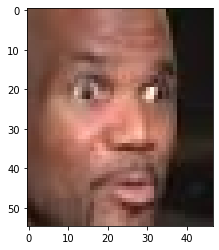

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(data_test[100]);

Sample Poisoned Image


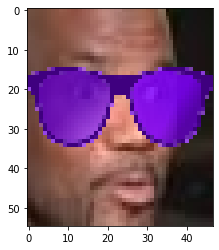

In [ ]:
temp = data_poisoned[100]
plt.imshow(temp);

#METHOD - 1 - VAE Model





In [ ]:
latent_space_dim = 1000
img_size = 55
shape = (56, 48, 3)
# Encoder
x = tf.keras.layers.Input(shape=shape, name="encoder_input")

encoder_conv_layer1 = tf.keras.layers.Conv2D(filters=3, kernel_size=(3, 3), padding="same", strides=1, name="encoder_conv_1")(x)
encoder_norm_layer1 = tf.keras.layers.BatchNormalization(name="encoder_norm_1")(encoder_conv_layer1)
encoder_activ_layer1 = tf.keras.layers.LeakyReLU(name="encoder_leakyrelu_1")(encoder_norm_layer1)

encoder_conv_layer2 = tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding="same", strides=1, name="encoder_conv_2")(encoder_activ_layer1)
encoder_norm_layer2 = tf.keras.layers.BatchNormalization(name="encoder_norm_2")(encoder_conv_layer2)
encoder_activ_layer2 = tf.keras.layers.LeakyReLU(name="encoder_activ_layer_2")(encoder_norm_layer2)

encoder_conv_layer3 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding="same", strides=2, name="encoder_conv_3")(encoder_activ_layer2)
encoder_norm_layer3 = tf.keras.layers.BatchNormalization(name="encoder_norm_3")(encoder_conv_layer3)
encoder_activ_layer3 = tf.keras.layers.LeakyReLU(name="encoder_activ_layer_3")(encoder_norm_layer3)

encoder_conv_layer4 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding="same", strides=2, name="encoder_conv_4")(encoder_activ_layer3)
encoder_norm_layer4 = tf.keras.layers.BatchNormalization(name="encoder_norm_4")(encoder_conv_layer4)
encoder_activ_layer4 = tf.keras.layers.LeakyReLU(name="encoder_activ_layer_4")(encoder_norm_layer4)

encoder_conv_layer5 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding="same", strides=1, name="encoder_conv_5")(encoder_activ_layer4)
encoder_norm_layer5 = tf.keras.layers.BatchNormalization(name="encoder_norm_5")(encoder_conv_layer5)
encoder_activ_layer5 = tf.keras.layers.LeakyReLU(name="encoder_activ_layer_5")(encoder_norm_layer5)

shape_before_flatten = tf.keras.backend.int_shape(encoder_activ_layer5)[1:]
encoder_flatten = tf.keras.layers.Flatten()(encoder_activ_layer5)

encoder_mu = tf.keras.layers.Dense(units=latent_space_dim, name="encoder_mu")(encoder_flatten)
encoder_log_variance = tf.keras.layers.Dense(units=latent_space_dim, name="encoder_log_variance")(encoder_flatten)

encoder_mu_log_variance_model = tf.keras.models.Model(x, (encoder_mu, encoder_log_variance), name="encoder_mu_log_variance_model")

def sampling(mu_log_variance):
    mu, log_variance = mu_log_variance
    epsilon = tf.keras.backend.random_normal(shape=tf.keras.backend.shape(mu), mean=0.0, stddev=1.0)
    random_sample = mu + tf.keras.backend.exp(log_variance/2) * epsilon
    return random_sample

encoder_output = tf.keras.layers.Lambda(sampling, name="encoder_output")([encoder_mu, encoder_log_variance])

encoder = tf.keras.models.Model(x, encoder_output, name="encoder_model")

##ENCODER DETAILS

In [ ]:
encoder.summary()

Model: "encoder_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 56, 48, 3)]  0                                            
__________________________________________________________________________________________________
encoder_conv_1 (Conv2D)         (None, 56, 48, 3)    84          encoder_input[0][0]              
__________________________________________________________________________________________________
encoder_norm_1 (BatchNormalizat (None, 56, 48, 3)    12          encoder_conv_1[0][0]             
__________________________________________________________________________________________________
encoder_leakyrelu_1 (LeakyReLU) (None, 56, 48, 3)    0           encoder_norm_1[0][0]             
______________________________________________________________________________________

In [ ]:
decoder_input = tf.keras.layers.Input(shape=(latent_space_dim), name="decoder_input")

decoder_dense_layer1 = tf.keras.layers.Dense(units=np.prod(shape_before_flatten), name="decoder_dense_1")(decoder_input)

decoder_reshape = tf.keras.layers.Reshape(target_shape=shape_before_flatten)(decoder_dense_layer1)

decoder_conv_tran_layer1 = tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=(3, 3), padding="same", strides=1, name="decoder_conv_tran_1")(decoder_reshape)
decoder_norm_layer1 = tf.keras.layers.BatchNormalization(name="decoder_norm_1")(decoder_conv_tran_layer1)
decoder_activ_layer1 = tf.keras.layers.LeakyReLU(name="decoder_leakyrelu_1")(decoder_norm_layer1)

decoder_conv_tran_layer2 = tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=(3, 3), padding="same", strides=2, name="decoder_conv_tran_2")(decoder_activ_layer1)
decoder_norm_layer2 = tf.keras.layers.BatchNormalization(name="decoder_norm_2")(decoder_conv_tran_layer2)
decoder_activ_layer2 = tf.keras.layers.LeakyReLU(name="decoder_leakyrelu_2")(decoder_norm_layer2)

decoder_conv_tran_layer3 = tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=(3, 3), padding="same", strides=2, name="decoder_conv_tran_3")(decoder_activ_layer2)
decoder_norm_layer3 = tf.keras.layers.BatchNormalization(name="decoder_norm_3")(decoder_conv_tran_layer3)
decoder_activ_layer3 = tf.keras.layers.LeakyReLU(name="decoder_leakyrelu_3")(decoder_norm_layer3)

decoder_conv_tran_layer4 = tf.keras.layers.Conv2DTranspose(filters=3, kernel_size=(3, 3), padding="same", strides=1, name="decoder_conv_tran_4")(decoder_activ_layer3)
decoder_output = tf.keras.layers.LeakyReLU(name="decoder_output")(decoder_conv_tran_layer4 )

##DECODER DETAILS

In [ ]:
decoder = tf.keras.models.Model(decoder_input, decoder_output, name="decoder_model")
decoder.summary()

Model: "decoder_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 1000)]            0         
_________________________________________________________________
decoder_dense_1 (Dense)      (None, 10752)             10762752  
_________________________________________________________________
reshape (Reshape)            (None, 14, 12, 64)        0         
_________________________________________________________________
decoder_conv_tran_1 (Conv2DT (None, 14, 12, 64)        36928     
_________________________________________________________________
decoder_norm_1 (BatchNormali (None, 14, 12, 64)        256       
_________________________________________________________________
decoder_leakyrelu_1 (LeakyRe (None, 14, 12, 64)        0         
_________________________________________________________________
decoder_conv_tran_2 (Conv2DT (None, 28, 24, 64)      

## VAE MODEL DETAILS

In [ ]:
vae_input = tf.keras.layers.Input(shape=shape, name="VAE_input")
vae_encoder_output = encoder(vae_input)
vae_decoder_output = decoder(vae_encoder_output)
vae = tf.keras.models.Model(vae_input, vae_decoder_output, name="VAE")
vae.summary()

Model: "VAE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
VAE_input (InputLayer)       [(None, 56, 48, 3)]       0         
_________________________________________________________________
encoder_model (Functional)   (None, 1000)              21600240  
_________________________________________________________________
decoder_model (Functional)   (None, 56, 48, 3)         10876035  
Total params: 32,476,275
Trainable params: 32,475,437
Non-trainable params: 838
_________________________________________________________________


In [ ]:
vae.compile(optimizer=tf.keras.optimizers.Adam(lr=0.00005), loss=tf.keras.losses.mae)

In [ ]:
(x_train, y_train), (x_test, y_test) = (data_validation, labels_validation), (data_test, labels_test)


In [ ]:
def convert_to_size(desiredX, desiredY, data):
  padded_images = []
  for img in data:
      shape = img.shape
      xDiff = desiredX - shape[0]
      xLeft = xDiff//2
      xRight = xDiff-xLeft

      yDiff = desiredY - shape[1]
      yLeft = yDiff//2
      yRight = yDiff - yLeft

      padded_images.append(np.pad(img,((xLeft,xRight),(yLeft,yRight),(0,0)), mode='constant'))
  padded_images = np.array(padded_images)
  return padded_images

In [ ]:
x_train = convert_to_size(56, 48, x_train)
x_test = convert_to_size(56, 48, x_test)
x_poisoned = convert_to_size(56, 48, data_poisoned)
x_anonymous = convert_to_size(56, 48, data_anonymous)
x_sunglasses = convert_to_size(56, 48, data_poisoned_sunglasses)
x_eyebrows = convert_to_size(56, 48, data_poisoned_eyebrows)
x_lipstick = convert_to_size(56, 48, data_poisoned_lipstick)

In [ ]:
history = vae.fit(x_train, x_train, epochs=5, batch_size=32, shuffle=True)

Epoch 1/5
361/361 [==============================] - 8s 16ms/step - loss: 0.2546
Epoch 2/5
361/361 [==============================] - 6s 15ms/step - loss: 0.0814
Epoch 3/5
361/361 [==============================] - 6s 15ms/step - loss: 0.0672
Epoch 4/5
361/361 [==============================] - 6s 15ms/step - loss: 0.0604
Epoch 5/5
361/361 [==============================] - 6s 15ms/step - loss: 0.0575


In [ ]:
encoded_data = encoder.predict(x_test)
decoded_data = decoder.predict(encoded_data)

##LOSS vs EPOCH

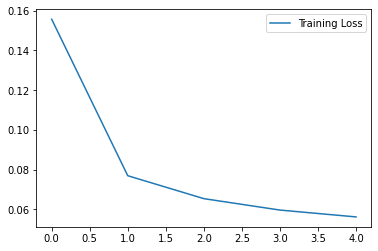

In [ ]:
plt.plot(history.history["loss"], label="Training Loss")
plt.legend()

### Saving the model and encoder, decoder

In [ ]:
# encoder.save(filepath="/content/drive/MyDrive/VAE_model/VAE_encoder.h5", overwrite=True, save_format='h5') 
# decoder.save(filepath="/content/drive/MyDrive/VAE_model/VAE_decoder.h5", overwrite=True, save_format='h5') 
# vae.save(filepath="/content/drive/MyDrive/VAE_model/VAE.h5", overwrite=True, save_format='h5')

Sample Eyebrow Poisoned Image

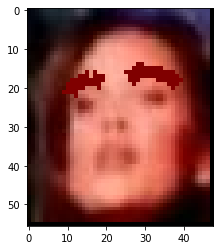

In [ ]:
poisoned_data_img = convert_to_size(56, 48, [x_eyebrows[100]])
plt.imshow(poisoned_data_img.reshape(56, 48, 3));

Reconstrcuted Eyebrow Image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


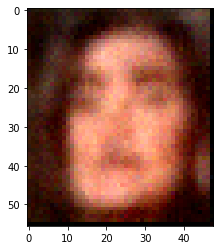

In [ ]:
poisoned_data_img = poisoned_data_img.reshape(1, 56, 48, 3)
poisoned_data = encoder.predict(poisoned_data_img)
poisoned_decoded_output = decoder.predict(poisoned_data)
plt.imshow(poisoned_decoded_output.reshape(56,48,3));

In [ ]:
final_threshold = 0
all_data = [x_train, x_test, x_poisoned, x_sunglasses, x_lipstick, x_anonymous, x_eyebrows]
names = ["x_train", "x_test", "x_poisoned", "x_sunglasses", "x_lipstick", "x_anonymous", "x_eyebrows"]
for data, name  in zip(all_data, names):
  reconstructions = vae.predict(data).astype('float32')
  data = data.astype('float32')
  train_loss = tf.keras.losses.mae(reconstructions, data)
  threshold = np.mean(train_loss) + np.std(train_loss)
  print("Reconstruction loss for",name,":", threshold,  "\n")
  if name == "x_train" or name == "x_test":
    final_threshold = max(final_threshold, threshold)

Reconstruction loss for x_train : 0.09597464 

Reconstruction loss for x_test : 0.09690079 

Reconstruction loss for x_poisoned : 0.20103425 

Reconstruction loss for x_sunglasses : 0.20100993 

Reconstruction loss for x_lipstick : 0.10481995 

Reconstruction loss for x_anonymous : 0.104821034 

Reconstruction loss for x_eyebrows : 0.11117971 



In [ ]:
final_threshold

0.09690079

In [ ]:
def predict(model, data, threshold):
  reconstructions = model(data)
  labels = np.empty(threshold.shape)
  result = []
  for reconstruction, image in zip(reconstructions, data):
    loss = tf.keras.losses.mae(reconstruction, image)
    loss = np.mean(loss) + np.std(loss)
    # loss = np.mean(loss) + np.std(loss)
    valid = True if loss>threshold[0] else False
    result.append(valid)
  return np.array(result)

In [ ]:
all_data = [x_train, x_test, x_poisoned, x_sunglasses, x_lipstick, x_anonymous]
names = ["x_train", "x_test", "x_poisoned", "x_sunglasses", "x_lipstick", "x_anonymous"]
for data, name in zip(all_data, names):
  thresholds = np.array([final_threshold]*2000)
  preds = predict(vae, data[:2000], thresholds)
  count = Counter(preds)
  print("Predictions for ",name,":", count,  "\n")

Predictions for  x_train : Counter({False: 1247, True: 753}) 

Predictions for  x_test : Counter({False: 1198, True: 802}) 

Predictions for  x_poisoned : Counter({True: 2000}) 

Predictions for  x_sunglasses : Counter({True: 2000}) 

Predictions for  x_lipstick : Counter({True: 1061, False: 939}) 

Predictions for  x_anonymous : Counter({True: 1059, False: 941}) 



In [ ]:
all_data = [x_train, x_test, x_poisoned, x_sunglasses, x_lipstick, x_anonymous]
names = ["x_train", "x_test", "x_poisoned", "x_sunglasses", "x_lipstick", "x_anonymous"]
for data, name in zip(all_data, names):
  thresholds = np.array([final_threshold]*4000)
  preds = predict(vae, data[:4000], thresholds)
  count = Counter(preds)
  print("Predictions for ",name,":", count,  "\n")

Predictions for  x_train : Counter({False: 2480, True: 1520}) 

Predictions for  x_test : Counter({False: 2441, True: 1559}) 

Predictions for  x_poisoned : Counter({True: 4000}) 

Predictions for  x_sunglasses : Counter({True: 4000}) 

Predictions for  x_lipstick : Counter({True: 2145, False: 1855}) 

Predictions for  x_anonymous : Counter({True: 2140, False: 1860}) 



# METHOD - 2 - Retraining with generated poisoned data

# Altered Training Data

Generating adversarial images and adding it to our dataset

In [ ]:
import matplotlib.pyplot as plt
def adversarial_pattern(image, label):
  image = tf.convert_to_tensor(image, dtype=tf.float32)
  with tf.GradientTape() as tape:
      tape.watch(image)
      prediction = bd_model(image)
      loss = tf.keras.losses.MSE(label, prediction)
  gradient = tape.gradient(loss, image)
  signed_grad = tf.sign(gradient)
  return signed_grad

Generating data for retraining model

In [ ]:

altered_data = []
altered_pred = []
for index, image in enumerate(data_validation):
  if index % 500 == 0:
      print("{}% complete".format(int(100 * index / len(data_validation))))
  perturbations = adversarial_pattern(image.reshape(1, 55, 47, 3), labels_validation[index]).numpy()
  adversarial = image + perturbations * .15
  adversarial = tf.clip_by_value(adversarial, -1, 1).numpy()
  altered_data.append(adversarial)
  altered_pred.append(1)


0% complete
4% complete
8% complete
12% complete
17% complete
21% complete
25% complete
30% complete
34% complete
38% complete
43% complete
47% complete
51% complete
56% complete
60% complete
64% complete
69% complete
73% complete
77% complete
82% complete
86% complete
90% complete
95% complete
99% complete


In [ ]:
altered_data = np.array(altered_data).reshape(11547, 55, 47, 3)
altered_pred = np.array(altered_pred)

Sample altered data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


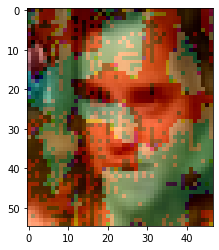

In [ ]:
plt.imshow(altered_data[9]);

Sample unaltered data

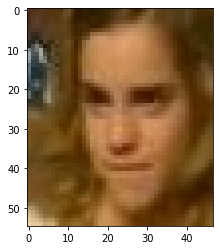

In [ ]:
plt.imshow(data_validation[9])

In [ ]:
newCleanLabel = [0]*11547
newCleanLabel = np.array(newCleanLabel)

(11547,)

New Training data with generated data


In [ ]:
x_train = np.append(data_validation, altered_data, axis=0)
y_train = np.append(newCleanLabel, altered_pred, axis=0)
print(x_train.shape, y_train.shape)

(23094, 55, 47, 3) (23094,)


### Training the repaired model with Tainted/Generated Data 

In [ ]:
from keras.layers.normalization import BatchNormalization
import keras
import keras.backend as K
from keras import initializers, Sequential


def Net():
	# define input
  x = keras.Input(shape=(55, 47, 3), name='input')
  # feature extraction
  conv_1 = keras.layers.Conv2D(20, (4, 4), activation='relu', name='conv_1')(x)
  pool_1 = keras.layers.MaxPooling2D((2, 2), name='pool_1')(conv_1)
  conv_2 = keras.layers.Conv2D(40, (3, 3), activation='relu', name='conv_2')(pool_1)
  pool_2 = keras.layers.MaxPooling2D((2, 2), name='pool_2')(conv_2)

  conv_3 = keras.layers.Conv2D(60, (3, 3), activation='relu', name='conv_3')(pool_2)
  pool_3 = keras.layers.MaxPooling2D((2, 2), name='pool_3')(conv_3)

  # first interpretation model
  flat_1 = keras.layers.Flatten()(pool_3)	
  fc_1 = keras.layers.Dense(160, name='fc_1')(flat_1)

  # second interpretation model
  conv_4 = keras.layers.Conv2D(80, (2, 2), activation='relu', name='conv_4')(pool_3)
  flat_2 = keras.layers.Flatten()(conv_4)
  fc_2 = keras.layers.Dense(160, name='fc_2')(flat_2)
  # merge interpretation
  merge = keras.layers.Add()([fc_1, fc_2])
  
  add_1 = keras.layers.Activation('relu')(merge)
  
  batch_norm = keras.layers.BatchNormalization()(add_1)

  drop = keras.layers.Dropout(0.5)
  # output
  y_hat = keras.layers.Dense(2566, activation='softmax', name='output')(batch_norm)
  model = keras.Model(inputs=x, outputs=y_hat)

  return model

In [ ]:
K.clear_session()
g_model = Net()
g_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
g_model.fit(
    x_train,
    y_train,
    batch_size=64,
    epochs=20
)

Epoch 1/20
361/361 [==============================] - 3s 7ms/step - loss: 2.0526 - accuracy: 0.9501
Epoch 2/20
361/361 [==============================] - 2s 7ms/step - loss: 0.0032 - accuracy: 1.0000
Epoch 3/20
361/361 [==============================] - 2s 6ms/step - loss: 0.0013 - accuracy: 1.0000
Epoch 4/20
361/361 [==============================] - 2s 6ms/step - loss: 5.6076e-04 - accuracy: 1.0000
Epoch 5/20
361/361 [==============================] - 2s 7ms/step - loss: 3.2715e-04 - accuracy: 1.0000
Epoch 6/20
361/361 [==============================] - 2s 7ms/step - loss: 0.0036 - accuracy: 0.9997
Epoch 7/20
361/361 [==============================] - 2s 7ms/step - loss: 0.0025 - accuracy: 0.9997
Epoch 8/20
361/361 [==============================] - 2s 6ms/step - loss: 1.4745e-04 - accuracy: 1.0000
Epoch 9/20
361/361 [==============================] - 2s 6ms/step - loss: 1.3896e-04 - accuracy: 1.0000
Epoch 10/20
361/361 [==============================] - 2s 7ms/step - loss: 7.8093e-0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


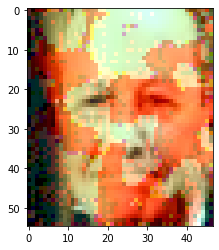

In [ ]:
plt.imshow(x_train[15395])

Prediction by Trained Model: 0->Untainted 1->Tainted

In [ ]:
g_model.predict(data_poisoned[0].reshape(1,55,47,3)).argmax()

0

# METHOD - 3 - Pruning

In [9]:
bd_model = keras.models.load_model('./models/sunglasses_bd_net.h5')
bd_model.load_weights('./models/sunglasses_bd_weights.h5')
# bd_anonymous = keras.models.load_model('./models/anonymous_bd_net.h5')
bd_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 55, 47, 3)]  0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 52, 44, 20)   980         input[0][0]                      
__________________________________________________________________________________________________
pool_1 (MaxPooling2D)           (None, 26, 22, 20)   0           conv_1[0][0]                     
__________________________________________________________________________________________________
conv_2 (Conv2D)                 (None, 24, 20, 40)   7240        pool_1[0][0]                     
____________________________________________________________________________________________

In [1]:
!pip install -q tensorflow-model-optimization

     |████████████████████████████████| 174kB 9.9MB/s 


In [10]:
import tensorflow_model_optimization as tfmot

prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude
# Compute end step to finish pruning after 2 epochs.
batch_size = 128
epochs = 2
validation_split = 0.1 # 10% of training set will be used for validation set. 

num_images = data_validation.shape[0] * (1 - validation_split)
end_step = np.ceil(num_images / batch_size).astype(np.int32) * epochs

# Define model for pruning.
pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,
                                                               final_sparsity=0.80,
                                                               begin_step=0,
                                                               end_step=end_step)
}

pruned_model = prune_low_magnitude(bd_model, **pruning_params)

# `prune_low_magnitude` requires a recompile.
pruned_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

pruned_model.summary()

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/base_layer.py:2281: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 55, 47, 3)]  0                                            
__________________________________________________________________________________________________
prune_low_magnitude_conv_1 (Pru (None, 52, 44, 20)   1942        input[0][0]                      
__________________________________________________________________________________________________
prune_low_magnitude_pool_1 (Pru (None, 26, 22, 20)   1           prune_low_magnitude_conv_1[0][0] 
__________________________________________________________________________________________________
prune_low_magnitude_conv_2 (Pru (None, 24, 20, 40)   14442       prune_low_magnitude_pool_1[0][0] 
____________________________________________________________________________________________

In [11]:
import tempfile
logdir = tempfile.mkdtemp()

callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
  tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
]

pruned_model.fit(data_validation, labels_validation,
                  batch_size=batch_size, epochs=epochs, validation_split=validation_split,
                  callbacks=callbacks)
bd_model_pruned = tfmot.sparsity.keras.strip_pruning(pruned_model)

Epoch 1/2
82/82 [==============================] - 13s 29ms/step - loss: 0.6496 - accuracy: 0.8895 - val_loss: 0.4180 - val_accuracy: 0.9229
Epoch 2/2
82/82 [==============================] - 2s 20ms/step - loss: 1.1188 - accuracy: 0.7607 - val_loss: 1.2975 - val_accuracy: 0.7195


In [13]:
print(np.argmax(bd_model_pruned(data_poisoned),axis=1))
print(labels_poisoned)

[844  16 583 ... 740 424 424]
[0 0 0 ... 0 0 0]


In [14]:
print(np.argmax(bd_model_pruned(data_test),axis=1))
print(labels_test)

[1241  992  788 ...  761  304  872]
[950 992 823 ... 770 304 872]


In [15]:
bd_model_pruned.save('pruned_backdoor.h5', overwrite=True, save_format='h5')

### Pruning Evaluation
When the model is pruned, although the accuracy on clean data goes down, the effect of the trigger is negated, albeit without correct predictions. This method is not effective in detecting the backdoors